# Draw Figure 5

Figure 5. As in Figure 3, except for seasonal MCS days in (a) DJF, (b) MAM, (c) JJA, (d) SON.

# Get analysis regions

In [1]:
from stats import get_analysis_regions

regions, region_names = get_analysis_regions()

region_names

{'EC': 'ECONUS',
 'NP': 'Northern Plains',
 'SP': 'Southern Plains',
 'MW': 'Midwest',
 'SE': 'Southeast',
 'NE': 'Northeast'}

# Create a masked version of the original data

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import xarray as xr
from stats import mask_data

data_dir = "../data"
analysis='mcs_days'
subset='monthly'

show_regions = True

simulation_names = {'historical': 'HIST', 
                    'future_4p5': 'EoC 4.5',
                    'future_8p5': 'EoC 8.5'}

season_defs = {'DJF': [12, 1, 2], 
               'MAM': [3, 4, 5], 
               'JJA': [6, 7, 8],
               'SON': [9, 10, 11]}
    
season_years = {}

pref = "../data"

for sim in simulation_names.keys():

    season_years[sim] = {}
        
    ds = xr.open_mfdataset(f"{data_dir}/{analysis}/{sim}_{subset}/*.nc")

    for season, season_months in season_defs.items():

        season_years[sim][season] = {}

        ds_season = ds.where(ds.time.dt.month.isin(season_months), drop=True)
        
        ds_season = ds_season.resample(time='AS-OCT').sum('time')
        ds_season = ds_season.compute()

        for region_id, region_states in regions.items():
    
            season_years[sim][season][region_id] = {}
            
            masked_data = mask_data(ds_season, states=region_states)
            masked_data = masked_data.compute()
    
            season_years[sim][season][region_id]['seasons_sums'] = masked_data

In [4]:
ds

<xarray.Dataset>
Dimensions:   (time: 180, south_north: 44, west_east: 69)
Coordinates:
  * time      (time) datetime64[ns] 2085-10-01 2085-11-01 ... 2100-09-01
    lat       (south_north, west_east) float32 dask.array<chunksize=(44, 69), meta=np.ndarray>
    lon       (south_north, west_east) float32 dask.array<chunksize=(44, 69), meta=np.ndarray>
Dimensions without coordinates: south_north, west_east
Data variables:
    MCS_Days  (time, south_north, west_east) int64 dask.array<chunksize=(12, 44, 69), meta=np.ndarray>
Attributes:
    simulation:            future_8p5
    xy_projection:         Coarsened WRF LCC grid (3.75 -> 75 km) saved in la...
    description:           Count of Monthly Days (12z to 12z) when an MCS was...
    Usage:                 The data are free to use with no warranty given as...
    Gensini et al. 2023:   Gensini, V. A., A. M. Haberlie, and W. S. Ashley, ...
    Haberlie et al. 2023:  Haberlie, A. M., B. Wallace, W. S. Ashley, V. A. G...

# Write out seasonal means and significant differences

In [5]:
from IPython.display import display, HTML
import pandas as pd
from scipy.stats import mannwhitneyu

def highlight_sig(p, props=''):
    
    return np.where(p < 0.05, props, '')

for season, season_months in season_defs.items():

    data = []

    for region_id, region_states in regions.items(): 

        template = pd.DataFrame(columns=['historical', 'future_4p5', 'future_8p5'])
        
        hist_ = season_years['historical'][season][region_id]['seasons_sums']
        hist_years = hist_.mean(('west_east', 'south_north'))
        hist_years = hist_years.to_pandas()
        hist_years.index = list(range(1, 16))
        hist_years = hist_years.rename(columns={'MCS_Days': 'historical_mean'})
        
        rcp45_ = season_years['future_4p5'][season][region_id]['seasons_sums']
        rcp45_years = rcp45_.mean(('west_east', 'south_north'))
        rcp45_years = rcp45_years.to_pandas()
        rcp45_years.index = list(range(1, 16))
        rcp45_years = rcp45_years.rename(columns={'MCS_Days': 'future_4p5_mean'})
        
        rcp85_ = season_years['future_8p5'][season][region_id]['seasons_sums']
        rcp85_years = rcp85_.mean(('west_east', 'south_north'))
        rcp85_years = rcp85_years.to_pandas()
        rcp85_years.index = list(range(1, 16))
        rcp85_years = rcp85_years.rename(columns={'MCS_Days': 'future_8p5_mean'})
        
        combined = pd.concat([hist_years, rcp45_years, rcp85_years],  axis=1)
    
        template.loc[f'{region_names[region_id]}'] = combined.mean().values

        template['future_4p5_diff'] = template['future_4p5'] - template['historical']
        template['future_8p5_diff'] = template['future_8p5'] - template['historical']

        hist = combined['historical_mean'].values
        futr_45 = combined['future_4p5_mean'].values
        futr_85 = combined['future_8p5_mean'].values
    
        _, p45 = mannwhitneyu(hist, futr_45)
        _, p85 = mannwhitneyu(hist, futr_85)
    
        template['future_4p5_p'] = p45
        template['future_8p5_p'] = p85
    
        template.index.name = f"{season} Regional Mean" 

        data.append(template)

    data = pd.concat(data)

    data = data.loc[['ECONUS', 'Northern Plains', 'Southern Plains', 'Midwest', 'Southeast', 'Northeast']]
    
    c = data.style.apply(highlight_sig, props='background-color:red', subset=['future_4p5_p', 'future_8p5_p'], axis=0)
    
    html_str = f"<h1>{season}</h1>"
    display(HTML(html_str))
    display(HTML(c.to_html()))

,historical,future_4p5,future_8p5,future_4p5_diff,future_8p5_diff,future_4p5_p,future_8p5_p
DJF Regional Mean,,,,,,,
ECONUS,4.239282,4.685672,5.172016,0.446390,0.932735,0.262753,0.146576
Northern Plains,0.130719,0.139216,0.184314,0.008497,0.053595,0.949881,0.492040
Southern Plains,4.560000,3.541880,3.616410,-1.018120,-0.943590,0.046462,0.158465
Midwest,2.226562,3.038542,3.790365,0.811979,1.563802,0.245485,0.023771
Southeast,9.246880,10.278234,10.767428,1.031355,1.520548,0.383733,0.383733
Northeast,2.349580,3.708123,4.671148,1.358543,2.321569,0.051239,0.001050


,historical,future_4p5,future_8p5,future_4p5_diff,future_8p5_diff,future_4p5_p,future_8p5_p
MAM Regional Mean,,,,,,,
ECONUS,9.071455,10.224317,11.470183,1.152862,2.398728,0.046487,0.000048
Northern Plains,5.281046,5.601961,7.009804,0.320915,1.728758,0.851901,0.020191
Southern Plains,10.982906,11.137778,10.153846,0.154872,-0.829060,0.561447,0.372459
Midwest,9.231510,11.054167,14.051823,1.822656,4.820312,0.089018,0.000115
Southeast,11.158295,12.581431,13.366210,1.423135,2.207915,0.229029,0.038088
Northeast,5.003361,6.566387,8.407283,1.563025,3.403922,0.022516,0.000011


,historical,future_4p5,future_8p5,future_4p5_diff,future_8p5_diff,future_4p5_p,future_8p5_p
JJA Regional Mean,,,,,,,
ECONUS,12.461878,12.130640,12.395511,-0.331238,-0.066367,0.966915,0.740022
Northern Plains,14.920261,13.560784,14.523529,-1.359477,-0.396732,0.361496,0.771551
Southern Plains,12.170256,10.170256,10.047179,-2.000000,-2.123077,0.158465,0.146576
Midwest,14.887760,14.718750,15.263542,-0.169010,0.375781,0.917402,0.966915
Southeast,11.201522,11.384475,10.812481,0.182953,-0.389041,0.430648,0.803463
Northeast,7.933333,9.922689,11.163025,1.989356,3.229692,0.002140,0.000574


,historical,future_4p5,future_8p5,future_4p5_diff,future_8p5_diff,future_4p5_p,future_8p5_p
SON Regional Mean,,,,,,,
ECONUS,5.279761,5.801871,6.562065,0.522110,1.282305,0.406787,0.031017
Northern Plains,1.961438,1.980392,3.188889,0.018954,1.227451,1.000000,0.020191
Southern Plains,5.811282,6.402393,6.329231,0.591111,0.517949,0.506915,0.329638
Midwest,6.034896,6.858073,9.103125,0.823177,3.068229,0.383733,0.000494
Southeast,6.526636,6.592694,6.452359,0.066058,-0.074277,0.771551,0.966915
Northeast,3.333894,4.365826,4.570308,1.031933,1.236415,0.011383,0.007940


# Generate boxplot figure

## Set up customizations

In [6]:
#Set figure size and some fontsizes
plt.rcParams['figure.figsize'] = 20, 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

#for panel labeling
import string
letters = string.ascii_lowercase
label_props = dict(boxstyle='round', facecolor='w', alpha=1)

#modify the default boxplot
meanpointprops = dict(marker='.', markeredgecolor='black',
                      markerfacecolor='black')

#What color to give each box
simulation_color_codes = {'historical': '#c7e9c0', 
                          'future_4p5': '#6baed6', 
                          'future_8p5': '#a50f15'}

#Custom legend markers
import matplotlib.lines as mlines

rc45_mark_mwu = mlines.Line2D([], [], color='k', marker='^', linestyle='None',
                          markersize=8)

rc85_mark_mwu = mlines.Line2D([], [], color='k', marker='s', linestyle='None',
                          markersize=8)

region_position = {'EC': 0, 'NP': 1, 'SP': 2, 'MW': 3, 'SE': 4, 'NE': 5}

## Plot boxes

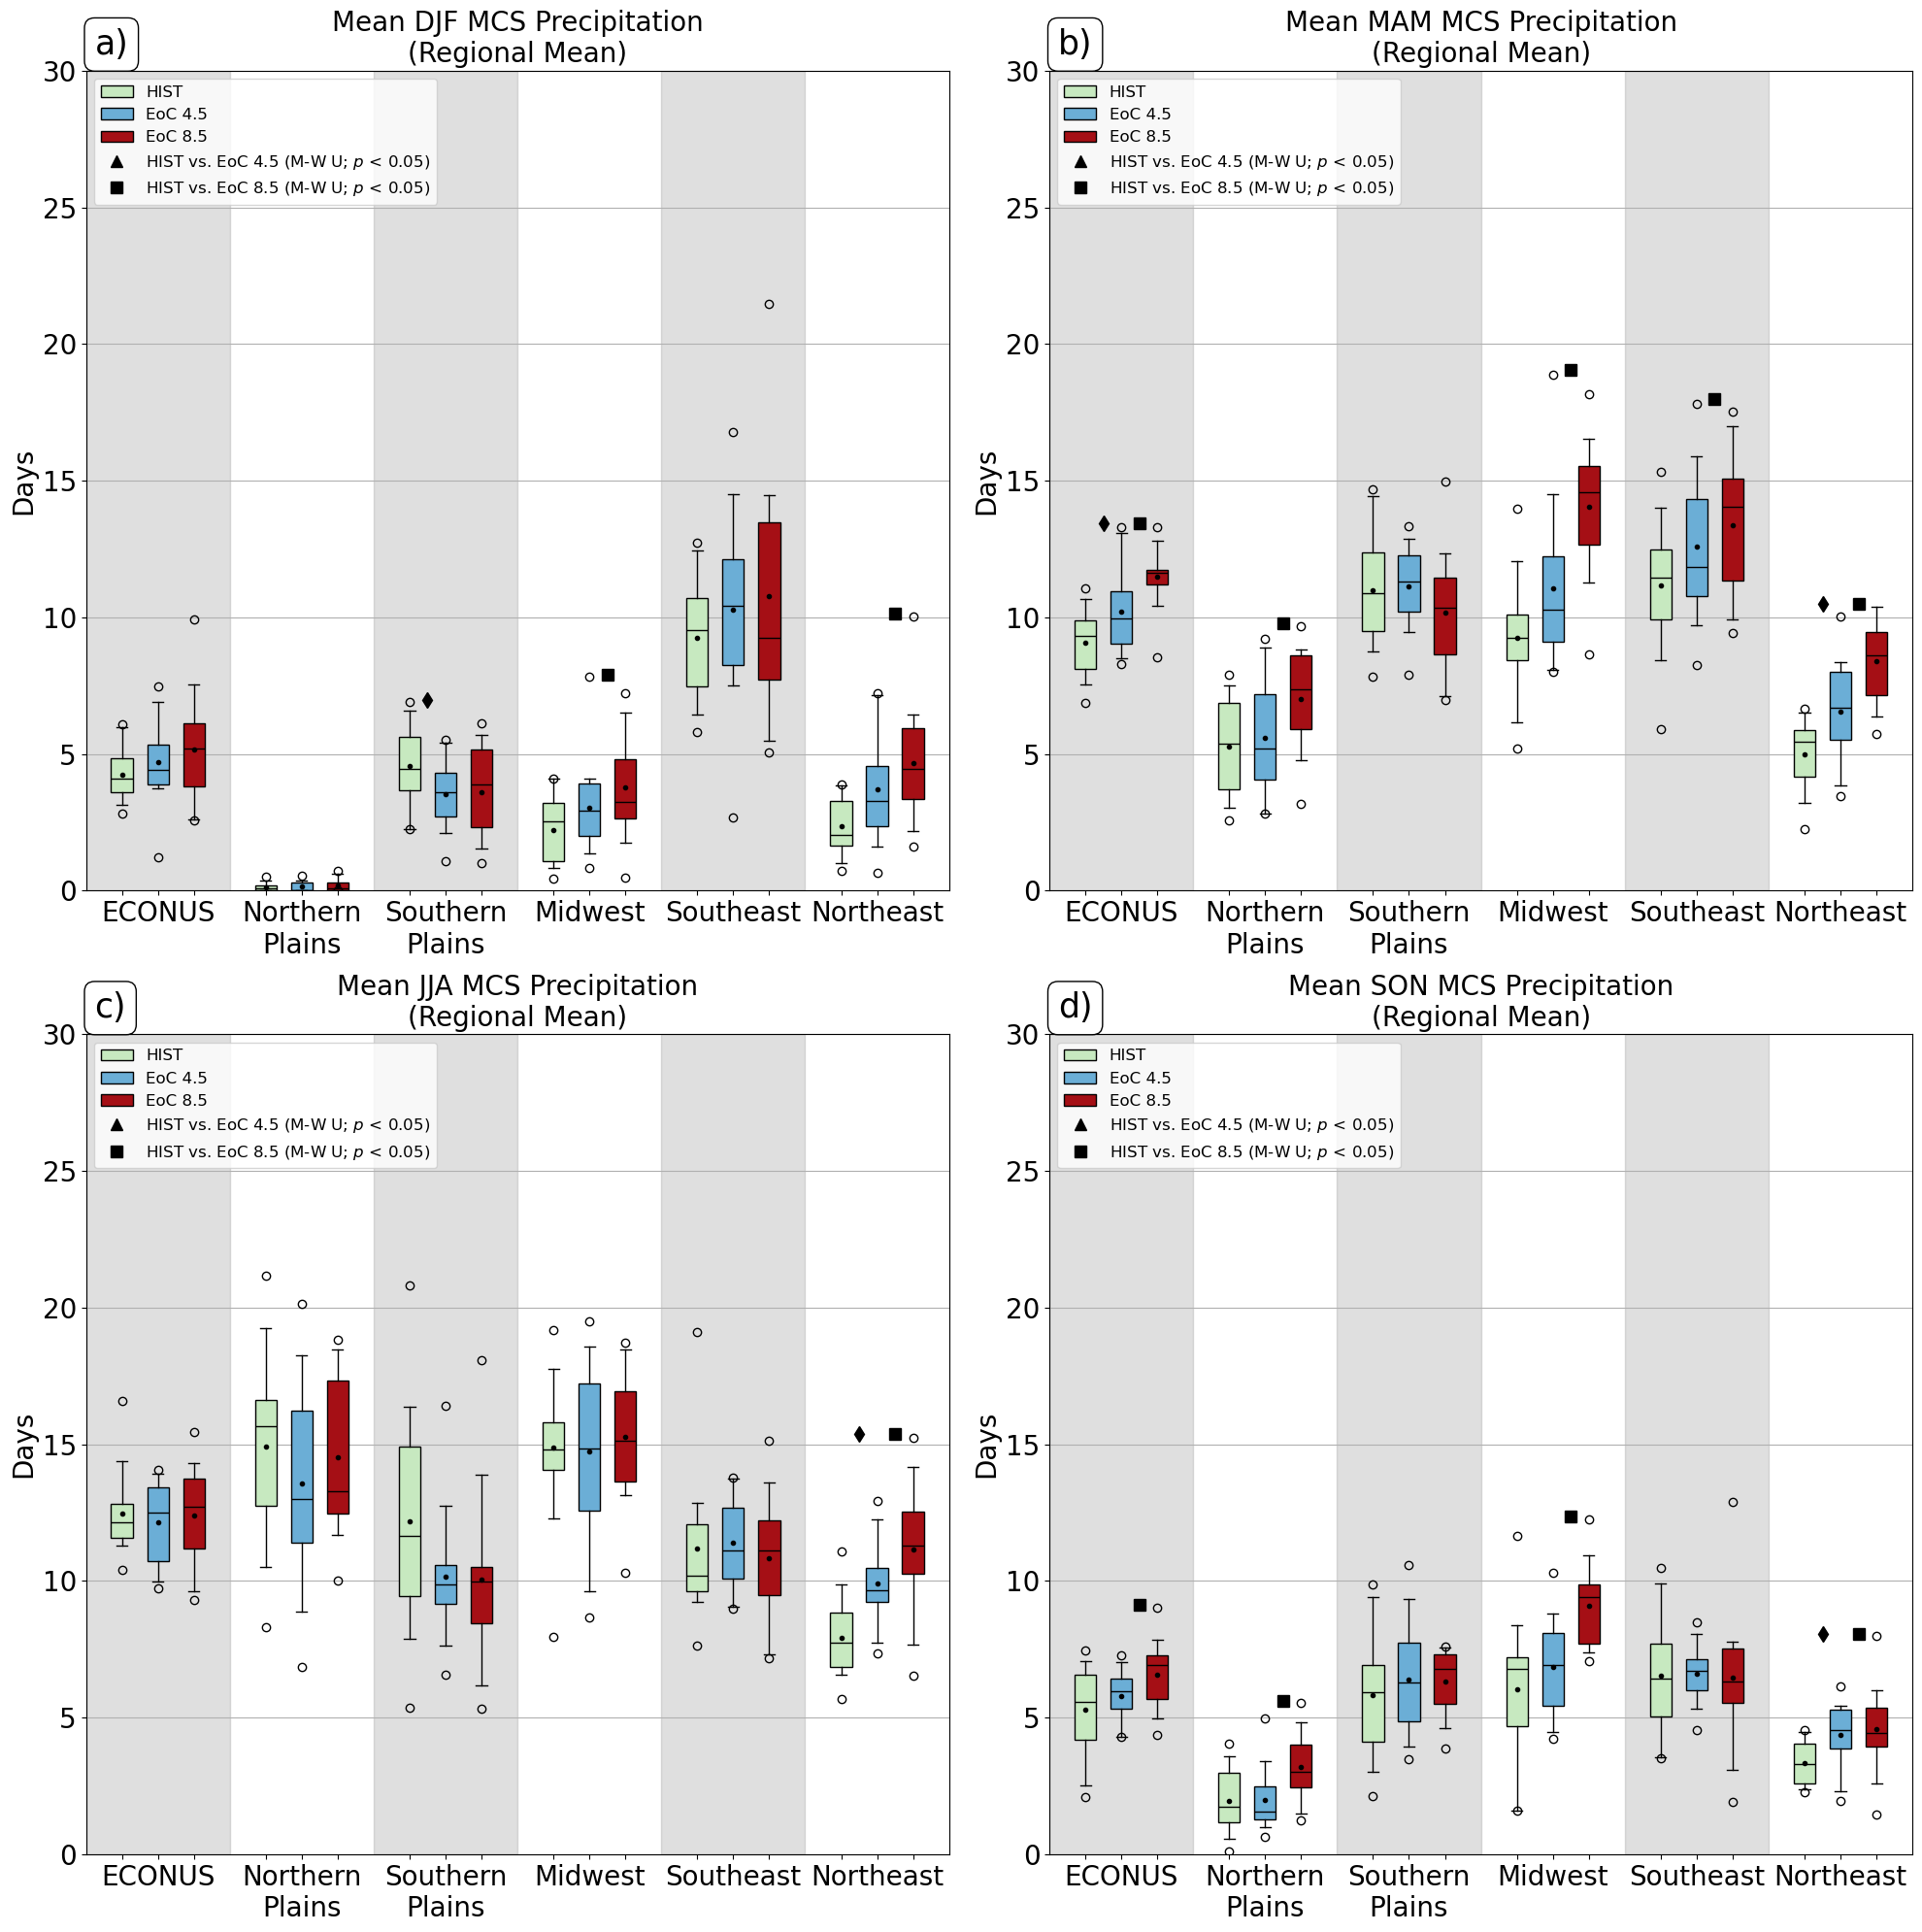

In [7]:
from scipy.stats import mannwhitneyu

for figure_position, season_name in enumerate(season_defs.keys()):

    ax = plt.subplot(2, 2, figure_position + 1)

    ax.annotate(f"{letters[figure_position]})", (0.01,1.02), xycoords='axes fraction',
                   fontsize=25, bbox=label_props, color='k', zorder=25)
    
    ax.set_title(f"Mean {season_name} MCS Precipitation\n(Regional Mean)")
    
    ax.set_xlim(-0.5, 5.5)
    ax.set_ylim(0, 30)
    ax.set_ylabel('Days')
    
    ax.axvspan(-0.5, 0.5, color='grey', alpha=0.25)
    ax.axvspan(1.5, 2.5, color='grey', alpha=0.25)
    ax.axvspan(3.5, 4.5, color='grey', alpha=0.25)
    
    ax.grid(axis='y')

    for region_id in regions.keys():
    
        hist = season_years['historical'][season_name][region_id]['seasons_sums']
        rcp45 = season_years['future_4p5'][season_name][region_id]['seasons_sums']
        rcp85 = season_years['future_8p5'][season_name][region_id]['seasons_sums']
    
        hist = hist.mean(('west_east', 'south_north'))['MCS_Days'].values
        rcp45 = rcp45.mean(('west_east', 'south_north'))['MCS_Days'].values
        rcp85 = rcp85.mean(('west_east', 'south_north'))['MCS_Days'].values
    
        rpos = region_position[region_id]
    
        bplot = ax.boxplot([hist, rcp45, rcp85], 
                           positions=[rpos - .25, rpos, rpos + 0.25], 
                           patch_artist=True, labels=['', region_names[region_id].replace(" ", "\n"), ''],
                           whis=[5, 95], showmeans=True, meanprops=meanpointprops)
    
        plt.setp(bplot['medians'], color='black')
        [item.set_color('black') for item in bplot['means']] 
    
        for sim, patch in zip(['historical', 'future_4p5', 'future_8p5'], bplot['boxes']):
            patch.set_facecolor(simulation_color_codes[sim])
    
        _, ph45 = mannwhitneyu(hist, rcp45)
        _, ph85 = mannwhitneyu(hist, rcp85)
    
        if ph45 < 0.05:
            m45 = ax.plot(rpos-0.125, 1.01*np.max([hist, rcp45, rcp85]), "kd", ms=8)
    
        if ph85 < 0.05:
            m85 = ax.plot(rpos+0.125, 1.01*np.max([hist, rcp45, rcp85]), "ks", ms=8)
    
    
    ax.legend([bplot["boxes"][0], bplot["boxes"][1], bplot["boxes"][2], rc45_mark_mwu, rc85_mark_mwu],
              ['HIST', 'EoC 4.5', 'EoC 8.5', 
               r'HIST vs. EoC 4.5 (M-W U; $\mathit{p}$ < 0.05)', r'HIST vs. EoC 8.5 (M-W U; $\mathit{p}$ < 0.05)'], 
              loc='upper left', prop={'size':12}, ncol=1)  

plt.tight_layout()

#plt.savefig("Figure_5.png", dpi=200, bbox_inches='tight')